# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

In [ ]:
!pip install xgboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#libraries to read and manipulate data
import numpy as np
import pandas as pd

#libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for model building and tuning
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier,RandomForestClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries for metrics and statistics
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading csv file into a pandas Dataframe
visa = pd.read_csv('/content/drive/MyDrive/Data Science- GL/5-Ensemble Techniques/Project 5: Ensemble Techniques: EasyVisa/EasyVisa.csv')
# copying data to another varaible to preserve original data
df = visa.copy()

In [ ]:
#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, feature_2, order, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    feature_2: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='viridis',
        order=order,
        hue=feature_2,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=9,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5), cmap='viridis')
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

## Data Overview

- Observations
- Sanity checks

In [ ]:
# print first five rows
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.20,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.65,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.86,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.03,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.39,Year,Y,Certified


In [ ]:
# print last five rows
df.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


In [ ]:
# print shape of dataset
df.shape

(25480, 12)

 **Observations**
- Dataset has 25,480 rows and 12 columns.

In [ ]:
# print the data types of the columns within the datset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [ ]:
# checking for duplicate values
df.duplicated()


0        False
1        False
2        False
3        False
4        False
         ...  
25475    False
25476    False
25477    False
25478    False
25479    False
Length: 25480, dtype: bool

In [ ]:
# checking for duplicate values
df[df.duplicated()]

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status


**Observations**
- There are no missing or duplicate values in the dataset.
- We should convert the object type columns to categories, which reduces the memory required to store the dataframe.

In [ ]:
# convert all columns with dtype object into category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

**Observations**
- There are 9 columns of the dtype object, 1 columns of the dtype float64, and 2 columns of the dtype int64.
- The target variable for the models is case_status.
- case_id is a randomly assigned by INA for each case, which should not provide any material information for model building.


In [ ]:
# drop the column *case_id* from the dataframe
df.drop(labels='case_id', axis=1, inplace=True)

In [ ]:
# confirm conversions and dropped variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  category
 1   education_of_employee  25480 non-null  category
 2   has_job_experience     25480 non-null  category
 3   requires_job_training  25480 non-null  category
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  category
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  category
 9   full_time_position     25480 non-null  category
 10  case_status            25480 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 797.7 KB


**Observations**
- The memory required to store the dataframe is now ~800kB, a third the size of the original dataframe

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 

2. How does the visa status vary across different continents? 
 
3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 
 
4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 
 
5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

## 1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification?

In [ ]:
#group data by education_of_employee and count the numbers of each case_status for each category
df.groupby('education_of_employee')['case_status'].value_counts()

education_of_employee  case_status
Bachelor's             Certified      6367
                       Denied         3867
Doctorate              Certified      1912
                       Denied          280
High School            Denied         2256
                       Certified      1164
Master's               Certified      7575
                       Denied         2059
Name: case_status, dtype: int64

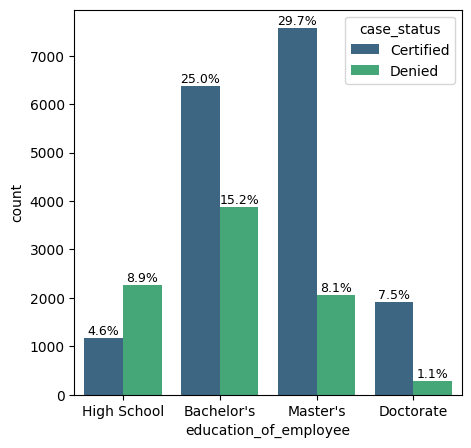

In [ ]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'education_of_employee','case_status', order=["High School","Bachelor's","Master's","Doctorate"], perc=True)

- As the graph aboves shows, the ratio of applications being certified versus denied increases considerably as an applicant's highest level of education achieved increases.
- The ratio of an applicant with a high school diploma being approved versus denied is ~1:2, whereas the same ratio for an applicant with a doctorate is ~7:1.

## 2. How does the visa status vary across different continents?

In [ ]:
#group data by continent and count the numbers of each case_status for each category
df.groupby('continent')['case_status'].value_counts()

continent      case_status
Africa         Certified        397
               Denied           154
Asia           Certified      11012
               Denied          5849
Europe         Certified       2957
               Denied           775
North America  Certified       2037
               Denied          1255
Oceania        Certified        122
               Denied            70
South America  Certified        493
               Denied           359
Name: case_status, dtype: int64

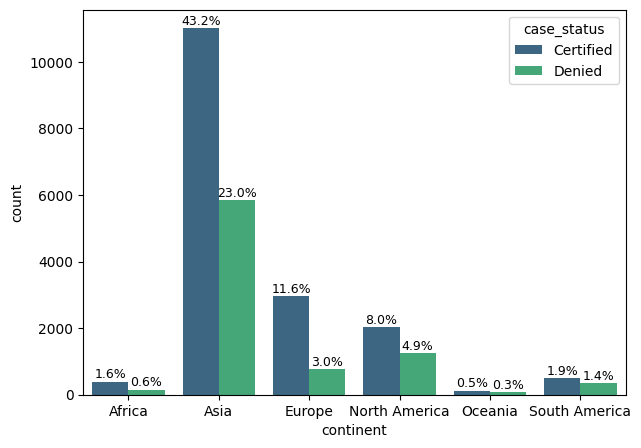

In [ ]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'continent','case_status', order=None, perc=True)

- Applicants from Asia comprise ~2/3 of all applications and these applicants have almost a 2:1 ratio of approvals to denials.
- An application from a European applicant has the best ratio of approvals to denials (~4:1).


## 3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status?

In [ ]:
#group data by has_job_experience and count the numbers of each case_status for each category
df.groupby('has_job_experience')['case_status'].value_counts()

has_job_experience  case_status
N                   Certified       5994
                    Denied          4684
Y                   Certified      11024
                    Denied          3778
Name: case_status, dtype: int64

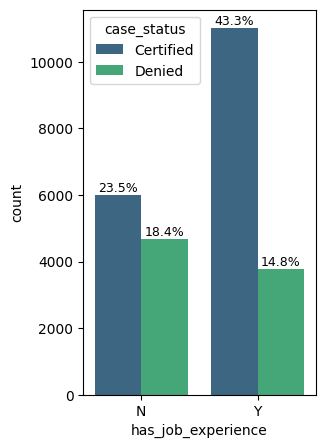

In [ ]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'has_job_experience','case_status', order=None, perc=True)

- Applicants with job experience have a ratio of approved to denied applications of ~3:1, whereas the same ratio for applicants without job experience have around a 5:4 ratio (i.e., approximately equivalent).

## 4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa?

In [ ]:
#group data by unit_of_wage and count the numbers of each case_status for each category
df.groupby('unit_of_wage')['case_status'].value_counts()

unit_of_wage  case_status
Hour          Denied          1410
              Certified        747
Month         Certified         55
              Denied            34
Week          Certified        169
              Denied           103
Year          Certified      16047
              Denied          6915
Name: case_status, dtype: int64

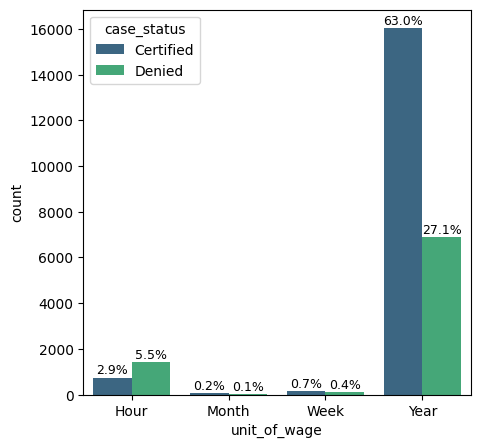

In [ ]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'unit_of_wage','case_status', order=None, perc=True)

- Applicants who are applying to work in a job with an hourly rate have a ratio of approved versus denied applications of ~1:2. Additionally, these applicants comprise only ~8% of all applications, but comprise ~17% of all denials.
- Applicants from any other unit_of_wage category have a ratio of ~2:1, with applications for jobs with annual salaries showing nearly a 2.5:1 ratio of approvals to denials.

## **5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?**

In [ ]:
#group data by unit_of_wage and calculate the mean prevailing_wage for each category
df.groupby('unit_of_wage')['prevailing_wage'].mean()


unit_of_wage
Hour      414.57
Month   87592.86
Week    85606.82
Year    81228.08
Name: prevailing_wage, dtype: float64

- The data shows that the unit_of_wage 'Hour' is a per-day amount, whearas the other three unit_of_wage categories are an annual salary amount.

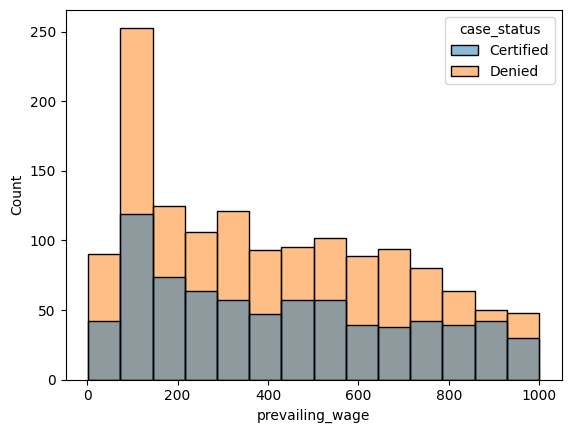

In [ ]:
#create a dataframe only of workers applying for jobs with a *unit_wage* of 'Hour'
df_hourly = df[df.unit_of_wage=='Hour']
#show a distribution of the *prevailing_wage* within this dataframe, along with the ratio of *case_status* within each bin
sns.histplot(data=df_hourly, x='prevailing_wage', hue='case_status')
plt.show()

In [ ]:
#create bins that categorize applicants by the per-day wage of the job he or she is applying for
bins = list(np.arange(0,1100,200))
#assign each applicant to a category
df_hourly['income_per_day'] = pd.cut(df_hourly['prevailing_wage'], bins)
df_hourly.groupby('income_per_day')['case_status'].value_counts()

income_per_day  case_status
(0, 200]        Denied         448
                Certified      219
(200, 400]      Denied         301
                Certified      166
(400, 600]      Denied         274
                Certified      144
(600, 800]      Denied         239
                Certified      116
(800, 1000]     Denied         148
                Certified      102
Name: case_status, dtype: int64

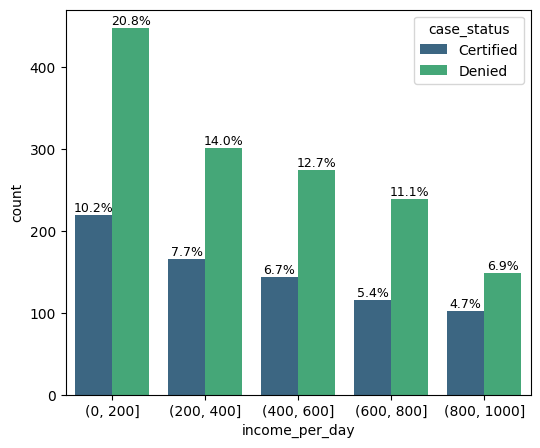

In [ ]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df_hourly,'income_per_day','case_status',perc=True,order=None)

- As the graphs above show, even within applicants for jobs with an 'Hour' prevailing_wage, the ratio of approved to denied applications increases considerably as prevailing_wage increases.
- Even at the highest income_per_day category, an application is still more likely to be denied than approved.

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering 
- Outlier detection and treatment (if needed)
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

In [ ]:
df.isna().sum()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

- There is no missing value to treat.


In [ ]:
#show the number of rows with a value of no_of_employees less than 0, which is not a possible value
df[df.no_of_employees<0].shape

(33, 11)

In [ ]:
#drop the rows with errors shown above and check the remaining number of rows
df = df[df.no_of_employees>0]
df.shape

(25447, 11)

In [ ]:
#create bins to categorize companies by the size of their overall workforce
bins = [0,1000,2000,3000,4000,np.Inf]
names = ['0-1000','1000-2000','2000-3000','3000-4000','4000+']
#assign each applicant to a category which indicates the size of the company he or she is applying to
df['company_size'] = pd.cut(df['no_of_employees'], bins, labels=names)
df.company_size.value_counts()

0-1000       6208
1000-2000    5915
2000-3000    4978
4000+        4798
3000-4000    3548
Name: company_size, dtype: int64

In [ ]:
#create bins to categorize companies by the number of years since the company was founded
bins = [0,1966,1986,1996,2006,np.Inf]
names = ['50+','30-50','20-30','10-20','0-10']
#assign each applicant to a category which indicates how long the company has been in business (i.e., a proxy for how well-established the company is)
df['company_age'] = pd.cut(df['yr_of_estab'], bins, labels=names)
df.company_age.value_counts()

10-20    8367
50+      5106
0-10     4849
30-50    3739
20-30    3386
Name: company_age, dtype: int64

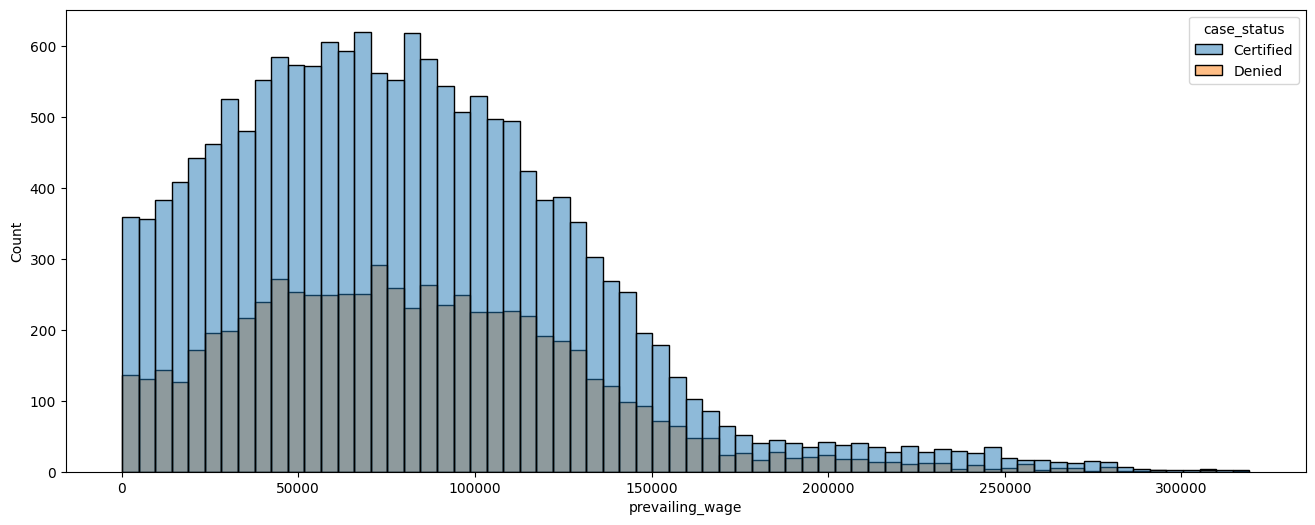

In [ ]:
#create a new dataframe of only those applicants applying for jobs with annual salaries (i.e., not 'Hour')
df_annual = df[df.unit_of_wage != "Hour"]
#show the distribution of annual salaries, along with ratio of *case_status* within each bin
plt.figure(figsize=(16,6))
sns.histplot(data=df_annual, x='prevailing_wage', hue='case_status')
plt.show()

- The distribution of wages is (as expected) right skewed, indicating a long-tail of jobs with annual salaries above 150,000 dollars.
- As the distribution above shows, the ratio of approved to denied applications remains approximately equivalent across the range of wages.

In [ ]:
#create bins to categorize a job by its annual salary, which indicates how well paying the job is
bins = [0,25000,50000,75000,100000,125000,np.inf]
names = ['$0-25k','$25k-50k','$50k-75k','$75k-100k','$100k-125k','$125k+']
#assign an applicant to a category
df_annual['income_per_year'] = pd.cut(df_annual['prevailing_wage'], bins, labels=names)
df_annual.groupby('income_per_year')['case_status'].value_counts()

income_per_year  case_status
$0-25k           Certified      2089
                 Denied          759
$25k-50k         Certified      2835
                 Denied         1232
$50k-75k         Certified      3132
                 Denied         1371
$75k-100k        Certified      3011
                 Denied         1315
$100k-125k       Certified      2405
                 Denied         1138
$125k+           Certified      2782
                 Denied         1225
Name: case_status, dtype: int64

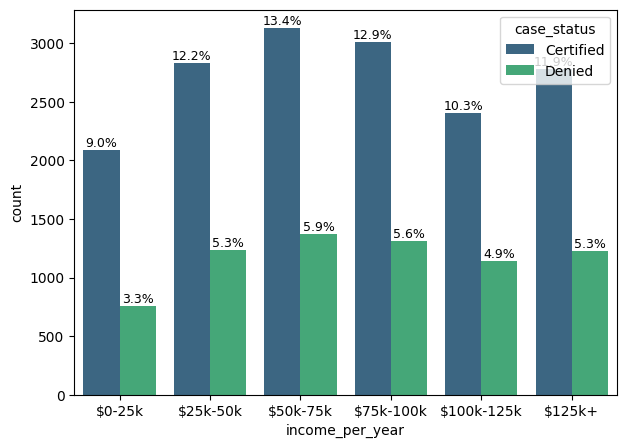

In [ ]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df_annual,'income_per_year','case_status',perc=True,order=None)

- In support of the observation above, there does not appear to be a significant change in ratio of approved to denied applications as income_per_year increases. To the contrary, the ratio may actually decrease as this prevailing_wage increases.
- For applications for jobs with an income_per_year wage, the highest concentration of applications is for jobs with 50,000 to 75,000 dollars per year in salary.

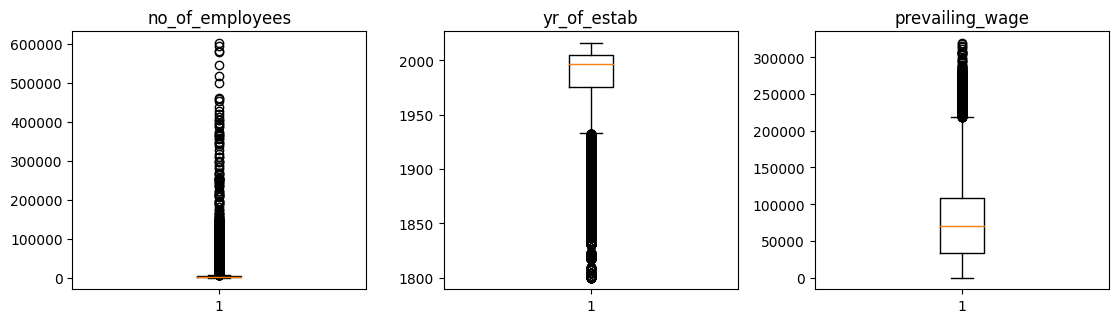

In [ ]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()


**Observations**

There are quite a few outliers in the data.
However, we will not treat them as they are proper values.

## EDA

- It is a good idea to explore the data once again after manipulating it.

In [ ]:
#provide summary statistics of all float64 variables
df_annual.describe(include = ['float64']).T

,count,mean,std,min,25%,50%,75%,max
prevailing_wage,23294.00,81312.84,49943.37,100.00,43860.93,76257.68,111414.45,319210.27


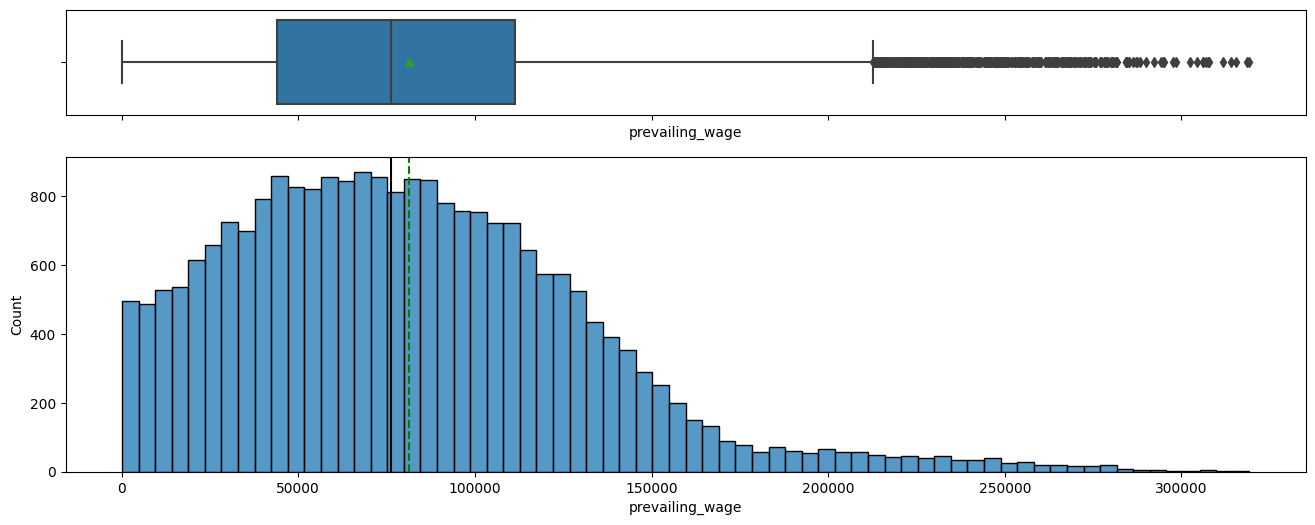

In [ ]:
#provide histogram and boxplot
histogram_boxplot(df_annual,'prevailing_wage')

In [ ]:
#provide summary statistics of all float64 variables
df_hourly.describe(include = ['float64']).T

,count,mean,std,min,25%,50%,75%,max
prevailing_wage,2157.00,414.57,275.02,2.14,152.70,372.65,637.31,999.92


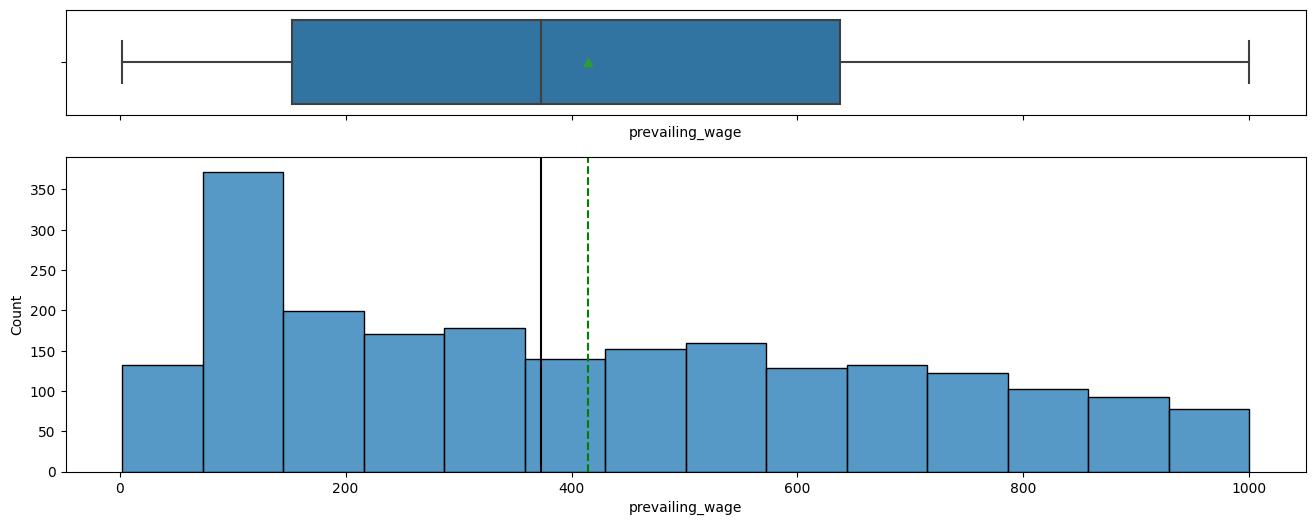

In [ ]:
#provide histogram and boxplot
histogram_boxplot(df_hourly,'prevailing_wage')

## Bivariate Analysis

continent    Africa   Asia  Europe  North America  Oceania  South America  \
case_status                                                                 
All             550  16840    3727           3287      192            851   
Certified       396  11001    2953           2037      122            492   
Denied          154   5839     774           1250       70            359   

continent      All  
case_status         
All          25447  
Certified    17001  
Denied        8446  
------------------------------------------------------------------------------------------------------------------------


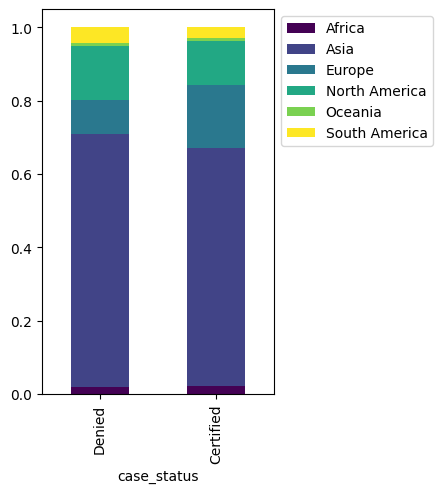

education_of_employee  Bachelor's  Doctorate  High School  Master's    All
case_status                                                               
All                         10220       2189         3416      9622  25447
Certified                    6362       1910         1164      7565  17001
Denied                       3858        279         2252      2057   8446
------------------------------------------------------------------------------------------------------------------------


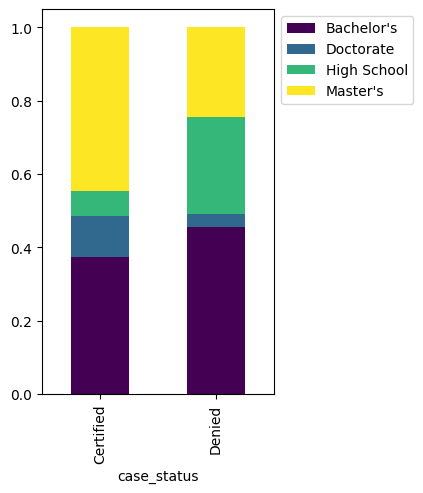

has_job_experience      N      Y    All
case_status                            
All                 10661  14786  25447
Certified            5986  11015  17001
Denied               4675   3771   8446
------------------------------------------------------------------------------------------------------------------------


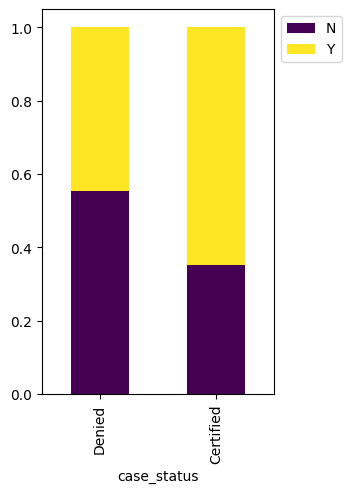

requires_job_training      N     Y    All
case_status                              
All                    22498  2949  25447
Certified              15000  2001  17001
Denied                  7498   948   8446
------------------------------------------------------------------------------------------------------------------------


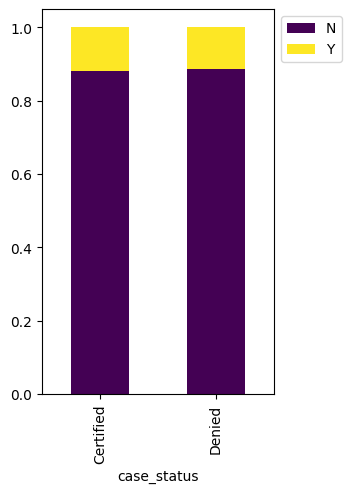

region_of_employment  Island  Midwest  Northeast  South  West    All
case_status                                                         
All                      375     4299       7189   7006  6578  25447
Certified                226     3246       4524   4908  4097  17001
Denied                   149     1053       2665   2098  2481   8446
------------------------------------------------------------------------------------------------------------------------


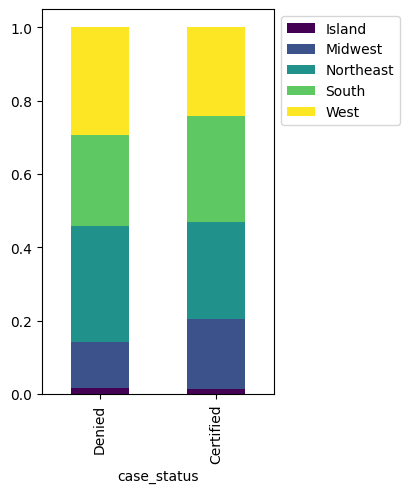

unit_of_wage  Hour  Month  Week   Year    All
case_status                                  
All           2153     89   272  22933  25447
Certified      747     55   169  16030  17001
Denied        1406     34   103   6903   8446
------------------------------------------------------------------------------------------------------------------------


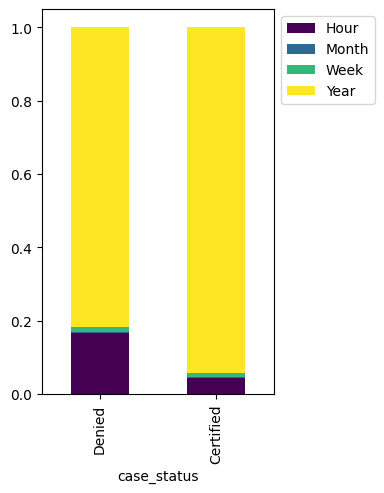

full_time_position     N      Y    All
case_status                           
All                 2706  22741  25447
Certified           1855  15146  17001
Denied               851   7595   8446
------------------------------------------------------------------------------------------------------------------------


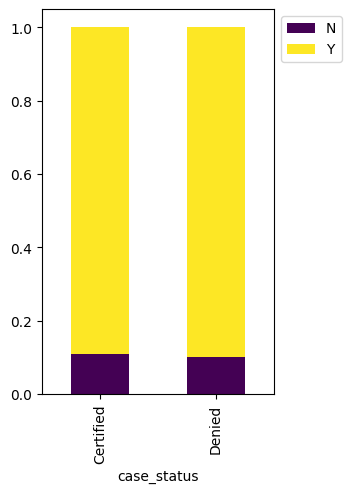

case_status  Certified  Denied    All
case_status                          
Denied               0    8446   8446
All              17001    8446  25447
Certified        17001       0  17001
------------------------------------------------------------------------------------------------------------------------


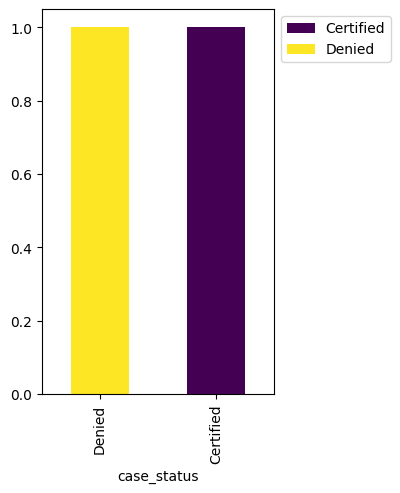

company_size  0-1000  1000-2000  2000-3000  3000-4000  4000+    All
case_status                                                        
All             6208       5915       4978       3548   4798  25447
Certified       4091       3878       3330       2341   3361  17001
Denied          2117       2037       1648       1207   1437   8446
------------------------------------------------------------------------------------------------------------------------


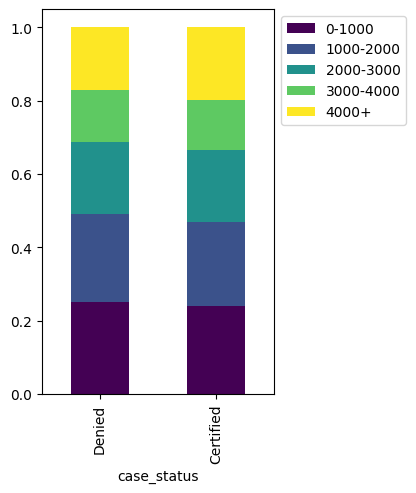

company_age   50+  30-50  20-30  10-20  0-10    All
case_status                                        
All          5106   3739   3386   8367  4849  25447
Certified    3385   2466   2226   5567  3357  17001
Denied       1721   1273   1160   2800  1492   8446
------------------------------------------------------------------------------------------------------------------------


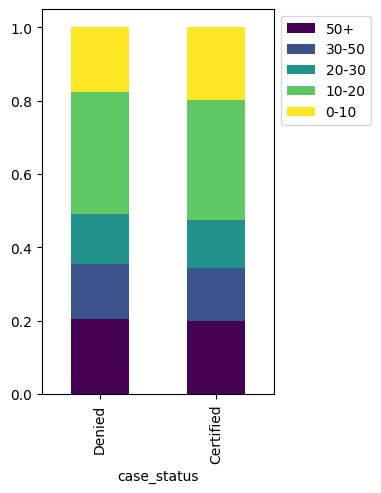

In [ ]:
#create a table and stacked barplot for each variable with a data type of category by case_status
cols_cat = df.select_dtypes(['category'])
for i in cols_cat.columns:
    stacked_barplot(df, "case_status", i)

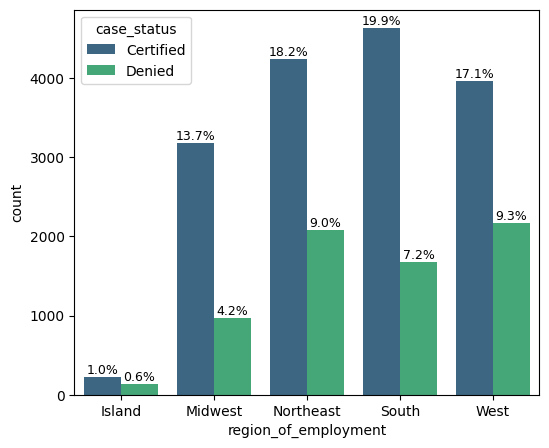

In [ ]:
#create a barplot of region of employment for an applicant's job with the corresponding percent of approved and denied cases for each
labeled_barplot(df_annual,'region_of_employment','case_status',perc=True,order=None)


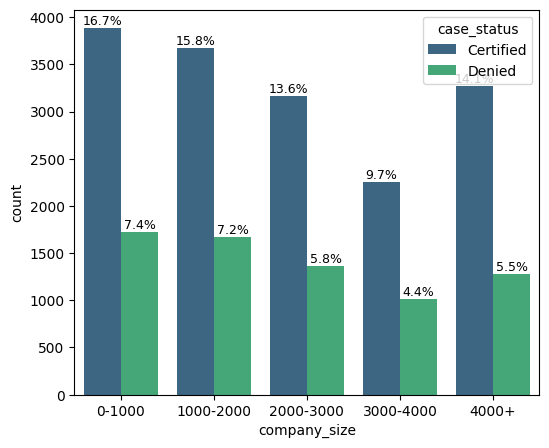

In [ ]:
#create a barplot of size of the company that an applicant is applying for with the corresponding percent of approved and denied cases for each
labeled_barplot(df_annual,'company_size','case_status',perc=True,order=None)

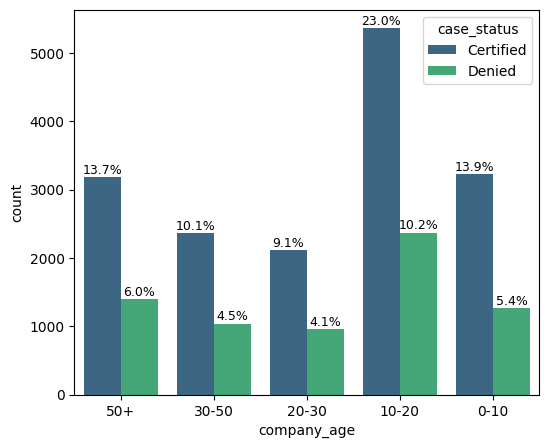

In [ ]:
#create a barplot of region of employment for an applicant's job with the corresponding percent of approved and denied cases for each
labeled_barplot(df_annual,'company_age','case_status',perc=True,order=None)

In [ ]:
#create tables listing the mean wage for each unique value within each variable with a data type category
for col in df_annual.dtypes[df_annual.dtypes == 'category'].index:
    print(df_annual.groupby(col)['prevailing_wage'].mean())
    print(" ")

continent
Africa          82817.44
Asia            86237.72
Europe          62148.78
North America   80015.78
Oceania         83806.39
South America   73641.62
Name: prevailing_wage, dtype: float64
 
education_of_employee
Bachelor's    81153.74
Doctorate     67498.27
High School   80905.55
Master's      84849.96
Name: prevailing_wage, dtype: float64
 
has_job_experience
N   86478.62
Y   77881.05
Name: prevailing_wage, dtype: float64
 
requires_job_training
N   80867.28
Y   84473.58
Name: prevailing_wage, dtype: float64
 
region_of_employment
Island      96323.02
Midwest     94900.09
Northeast   77091.74
South       82174.41
West        74720.82
Name: prevailing_wage, dtype: float64
 
unit_of_wage
Hour         NaN
Month   87592.86
Week    85606.82
Year    81237.54
Name: prevailing_wage, dtype: float64
 
full_time_position
N   105484.60
Y    78161.02
Name: prevailing_wage, dtype: float64
 
case_status
Certified   80816.02
Denied      82459.91
Name: prevailing_wage, dtype: float64
 
compa

In [ ]:
#create tables listing the mean wage for each unique value within each variable with a data type category
for col in df_hourly.dtypes[df_hourly.dtypes == 'category'].index:
    print(df_hourly.groupby(col)['prevailing_wage'].mean())
    print(" ")

continent
Africa          399.13
Asia            421.73
Europe          398.23
North America   406.19
Oceania         477.20
South America   392.17
Name: prevailing_wage, dtype: float64
 
education_of_employee
Bachelor's    412.73
Doctorate     414.55
High School   418.06
Master's      415.19
Name: prevailing_wage, dtype: float64
 
has_job_experience
N   413.97
Y   415.61
Name: prevailing_wage, dtype: float64
 
requires_job_training
N   415.67
Y   382.34
Name: prevailing_wage, dtype: float64
 
region_of_employment
Island      275.65
Midwest     427.30
Northeast   406.20
South       425.97
West        414.46
Name: prevailing_wage, dtype: float64
 
unit_of_wage
Hour    414.57
Month      NaN
Week       NaN
Year       NaN
Name: prevailing_wage, dtype: float64
 
full_time_position
N   488.47
Y   413.91
Name: prevailing_wage, dtype: float64
 
case_status
Certified   424.92
Denied      409.09
Name: prevailing_wage, dtype: float64
 
income_per_day
(0, 200]      111.97
(200, 400]    297.40
(400

**Additional EDA observations**
  - In addition to the analysis above on the ratio of approved to denied applications by education, previous job experience, continent, prevailing wage, and unit of wage:
    * If a job does or does not require training does not affect this ratio.
    * If a job is a full-time position or not does not affect this ratio.
    * If a job is located in the Midwest or South region, applicants have a higher ratio of approvals than those in the Northeast, West, and particularly the Island region.
    * Jobs that applicants with doctorate degree are applying for jobs have the lowest mean prevailing wage of any education.
    * Temporary (i.e., not full-time) jobs that applicants are applying for have a significantly higher prevailing wage than full-time positions.

Data Preprocessing continuing

### - Preparing data for modeling
### - Splitting the data 



In [ ]:

#drop the int_64 columns from the dataframe, since this information is captured through the features engineered above
df_model = df.drop(labels=['no_of_employees','yr_of_estab'], axis=1, inplace=True)

Encoding Certified as 1 and Denied as 0, as the OFLC wants to identify those visa applicants who are predicted to be approved.

In [ ]:
df["case_status"] = df["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

### Spliting the data
* We will use 70% of data for training and 30% for testing.

In [ ]:
#create a dataframe of the predictor feature columns
X = df.drop('case_status',axis=1)
#create a datafrane of the predicted class (1=True, 0=False)
Y = df['case_status']

#generate dummy variables for each categorical variable
X = pd.get_dummies(X, drop_first=True)

#split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [ ]:
#confirm the split
print("{0:0.2f}% data is in training set".format((len(x_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(df.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [ ]:
#confirm the shape of both data sets and the ratio of classes is the same across both train and test datasets
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)
print(' ')
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17812, 27)
Shape of test set :  (7635, 27)
 
Percentage of classes in training set:
1   0.67
0   0.33
Name: case_status, dtype: float64
 
Percentage of classes in test set:
1   0.67
0   0.33
Name: case_status, dtype: float64


## Building bagging and boosting models

## Model evaluation criterion
### Model can make wrong predictions as:


1.   Predicting an applicant should be approved the applicant is denied.
2.   Predicting an applicant should be denied and the applicant is approved


### Which case is more important?

* Both are important:
  * If an applicant is approved when they would have been denied, an unqualified employee will get a job that should have been filled by a US citizen.
  * If an applicant is denied when they should have been approved, U.S. companies will not be able to fill critical positions and the overall economy will not be as productive.

### How to reduce the losses?
*   As the process of reviewing each application is time and resource-intensive, this model should identify those candidates predicted to be approved, so agents can prioritize these applications
*   F1 Score can be used a the metric for evaluation of the model, as the greater the F1 score, the higher the chances of minimizing False Negatives and False Positives.
*   We will use balanced class weights, where applicable, so that model focuses equally on both classes.







**Defining functions to provide metric scores (i.e., accuracy, recall, and precision) on the train and test datasets and to show the resulting confusion matrices.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Decision Tree Model
- We will build our model using the DecisionTreeClassifier function, using default 'gini' criteria to split.

In [ ]:
dtree = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced')

In [ ]:
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

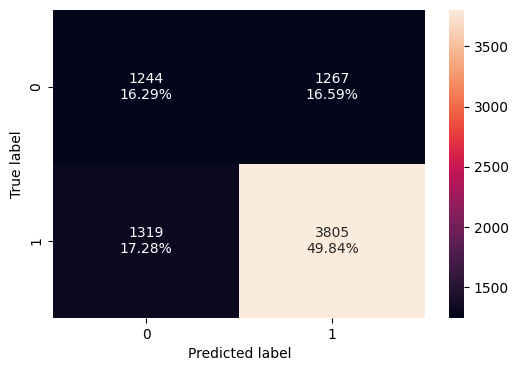

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree, x_test, y_test)

**Confusion Matrix -**

* Applicant was approved and the model predicted approval : True Positive (observed=1,predicted=1)

* Applicant was denied and the model predicted approval : False Positive (observed=0,predicted=1)

* Applicant was denied and the model predicted denial : True Negative (observed=0,predicted=0)

* Applicant was approved and the model predicted denial : False Negative (observed=1,predicted=0)

In [ ]:
dtree_model_train_perf=model_performance_classification_sklearn(dtree, x_train, y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


In [ ]:
dtree_model_test_perf=model_performance_classification_sklearn(dtree, x_test, y_test)
print("Testing performance \n",dtree_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.66    0.74       0.75 0.75


- The Decision Tree is working well on the training data, but is not able to generalize well on the test data, indicating the model is overfit.

## Bagging Classifier

In [ ]:
bagging = BaggingClassifier(random_state=1)
bagging.fit(x_train,y_train)

BaggingClassifier(random_state=1)

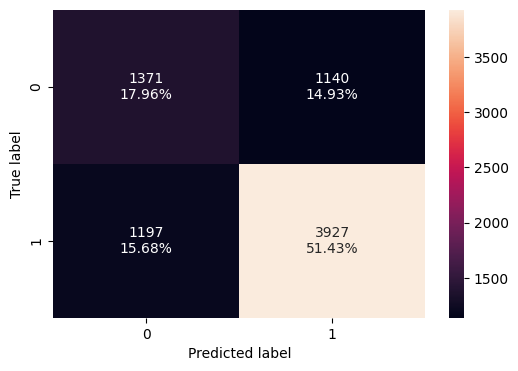

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(bagging, x_test, y_test)

In [ ]:
bagging_model_train_perf=model_performance_classification_sklearn(bagging, x_train, y_train)
print("Training performance \n",bagging_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.98    0.98       0.99 0.99


In [ ]:
bagging_model_test_perf=model_performance_classification_sklearn(bagging, x_test, y_test)
print("Testing performance \n",bagging_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.69    0.77       0.78 0.77


- Similar to the Decision Tree model, this bagging classifer is overfit to the training dataset but has a higher F1 score.

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

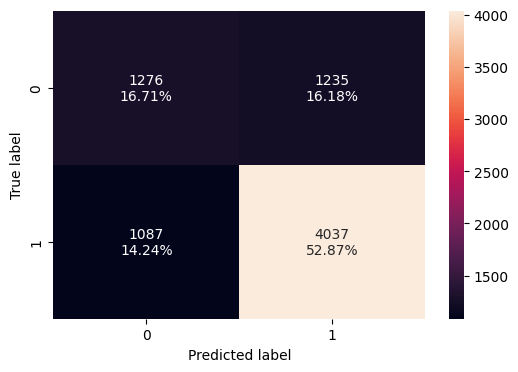

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf,x_test,y_test)

In [ ]:
rf_model_train_perf=model_performance_classification_sklearn(rf,x_train,y_train)
print("Training performance \n",rf_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


In [ ]:
rf_model_test_perf=model_performance_classification_sklearn(rf,x_test,y_test)
print("Testing performance \n",rf_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.70    0.79       0.77 0.78


- Similar to the models above, this Random Forest is also overfit to the training dataset but has the highest F1 score so far.

## AdaBoost Classifier

In [ ]:
ab_classifier=AdaBoostClassifier(random_state=1)
ab_classifier.fit(x_train,y_train)

AdaBoostClassifier(random_state=1)

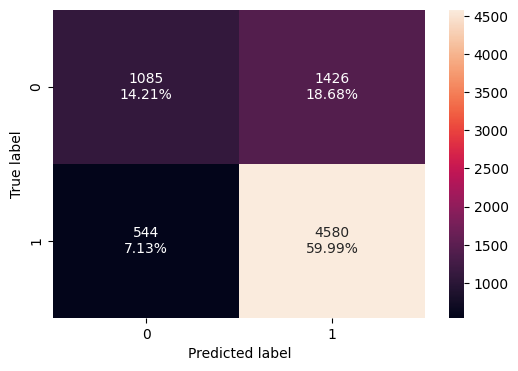

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(ab_classifier, x_test,y_test)


In [ ]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier,x_train,y_train)
print("Training performance \n",ab_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.88       0.76 0.82


In [ ]:
ab_classifier_model_test_perf = model_performance_classification_sklearn(ab_classifier,x_test,y_test)
print("Testing performance \n",ab_classifier_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.74    0.89       0.76 0.82


- This AdaBoost classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
- Additionally, the model performs the best of any model yet (i.e., highest F1 score) on the testing data.

## Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(x_train,y_train)

GradientBoostingClassifier(random_state=1)

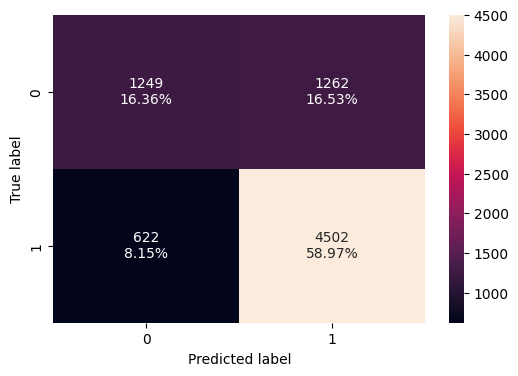

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(gbc, x_test,y_test)

In [ ]:
gbc_classifier_model_train_perf = model_performance_classification_sklearn(gbc,x_train,y_train)
print("Training performance \n",gbc_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.87       0.78 0.83


In [ ]:
gbc_classifier_model_test_perf = model_performance_classification_sklearn(gbc,x_test,y_test)
print("Training performance \n",gbc_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.88       0.78 0.83


- This Gradient Boosting classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
- Additionally, this model performs even better than the AdaBoost model above.

## XGBoost Classifier

In [ ]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

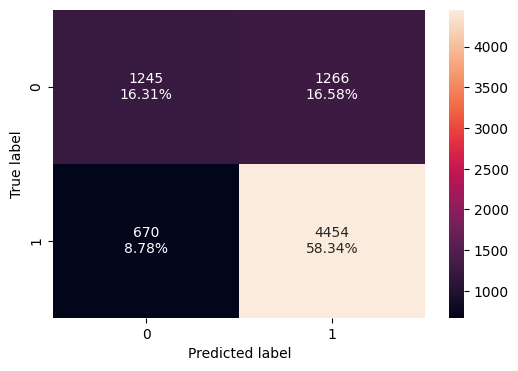

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(xgb, x_test,y_test)

In [ ]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb,x_train,y_train)
print("Training performance \n",xgb_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.81    0.92       0.82 0.87


In [ ]:
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb,x_test,y_test)
print("Training performance \n",xgb_classifier_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.87       0.78 0.82


- This XGBoost classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
- Additionally, this model performs as well as the AdaBoost model and slightly worse the Gradient Boost model on the test data.

# Base models comparison

In [ ]:
# create a dataframe comparing the performance of the base models on the training data

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,
     bagging_model_train_perf.T,
     rf_model_train_perf.T,
     ab_classifier_model_train_perf.T, 
     gbc_classifier_model_train_perf.T, 
     xgb_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Training performance comparison of base models:")
models_train_comp_df

Training performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,1.00,0.98,1.00,0.73,0.75,0.81
Recall,1.00,0.98,1.00,0.88,0.87,0.92
Precision,1.00,0.99,1.00,0.76,0.78,0.82
F1,1.00,0.99,1.00,0.82,0.83,0.87


In [ ]:
# create a dataframe comparing the performance of the base models on the testing data

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T,
     bagging_model_test_perf.T,
     rf_model_test_perf.T,
     ab_classifier_model_test_perf.T, 
     gbc_classifier_model_test_perf.T, 
     xgb_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Testing performance comparison of base models:")
models_test_comp_df

Testing performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,0.66,0.69,0.70,0.74,0.75,0.75
Recall,0.74,0.77,0.79,0.89,0.88,0.87
Precision,0.75,0.78,0.77,0.76,0.78,0.78
F1,0.75,0.77,0.78,0.82,0.83,0.82


- Overall, the bagging models perform best on the training data, due to all three of the models overfitting this data set.
- As shown above, all three of the boosting models do not overfit the data and achieve higher F1 scores on the training data set, with the Gradient Boosting classifier performing the best.

##  Will tuning the hyperparameters improve the model performance?

#Hyperparameter tuning

###Tuning Decision Tree

In [ ]:
# Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(5,30,5),
              'min_samples_leaf': [3, 5, 7],
              'max_leaf_nodes' : [2, 4, 6],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

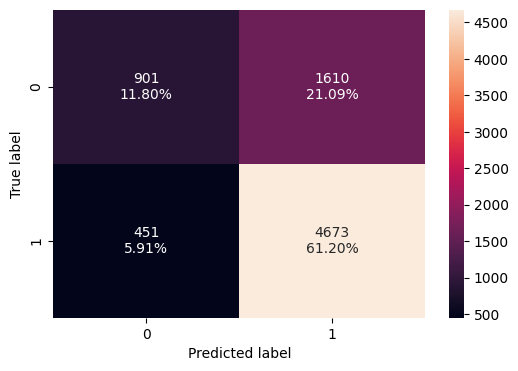

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree_estimator, x_test,y_test)

In [ ]:
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator, x_train,y_train)
print("Training performance \n",dtree_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


In [ ]:
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator, x_test, y_test)
print("Testing performance \n",dtree_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


- The Decision Tree model after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
- Additionally, this model performs as well as two out of the three boosting models above on the test data.
- Both of these indicate this tuned model is a significant improvements over the base model.

### Tuning Bagging Classifier

Hyperparameters available for bagging classifier include:

 - base_estimator: The base estimator to fit on random subsets of the dataset. If None(default), then the base estimator is a decision tree.
 - n_estimators: The number of trees in the forest, default = 100.
 - max_features: The number of features to consider when looking for the best split.
 - bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.
 - bootstrap_features: If it is true, then features are drawn with replacement. Default value is False.
 - max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.
 - oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

In [ ]:
# random search for bagging classifier
parameters = {'max_samples': [0.7,0.8,0.9,1],
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : np.arange(50, 100, 10)
             }

#run the randomized search
rand_bag = RandomizedSearchCV(BaggingClassifier(random_state=1,bootstrap=True), 
                              parameters, scoring = 'f1', cv = 5, random_state=1)
rand_bag = rand_bag.fit(x_train, y_train)

# Set the clf to the best combination of parameters
bag_tuned = rand_bag.best_estimator_

# Fit the best algorithm to the data
bag_tuned.fit(x_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.8, n_estimators=70,
                  random_state=1)

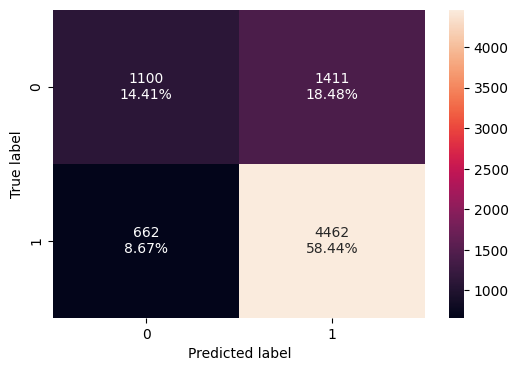

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(bag_tuned, x_test,y_test)


In [ ]:
bagging_estimator_model_train_perf=model_performance_classification_sklearn(bag_tuned, x_train,y_train)
print("Training performance \n",bagging_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.99    1.00       0.99 0.99


In [ ]:
bagging_estimator_model_test_perf=model_performance_classification_sklearn(bag_tuned, x_test, y_test)
print("Testing performance \n",bagging_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.87       0.76 0.81


- The Bagging Classifier after tuning performs far less well on the test data than on the training data, indicating that the model is still overfit.
- However, this model does perform better than the base model.

##Tuning Random Forest

Hyperparameters for Random Forest include:

 - n_estimators: The number of trees in the forest, default = 100.

 - max_features: The number of features to consider when looking for the best split.

 - class_weight: Weights associated with classes in the form {class_label: weight}.If not given, all classes are supposed to have weight one.

 - F or example: If the frequency of class 0 is 80% and the frequency of class 1 is 20% in the data, then class 0 will become the dominant class and the model will become biased toward the dominant classes. In this case, we can pass a dictionary {0:0.2,1:0.8} to the model to specify the weight of each class and the random forest will give more weightage to class 1.

 - bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.

 - max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.

 - oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

 - Note: A lot of hyperparameters of Decision Trees are also available to tune Random Forest like max_depth, min_sample_split etc.

In [ ]:
# Choose the type of classifier. 
rf_estimator = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10, 40, 10),
              "min_samples_leaf": np.arange(5, 10),
              "min_samples_split": [3, 5, 7],
              "max_features": ["sqrt", "log2"],
              "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Run the randomized search
rand_rf = RandomizedSearchCV(rf_estimator, parameters, scoring='f1', cv=5, n_jobs=-1, random_state=1)
rand_rf = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = rand_rf.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

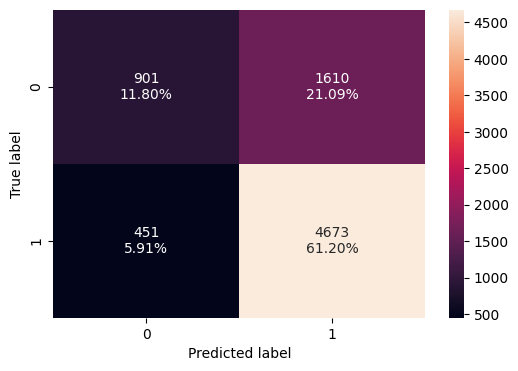

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf_estimator, x_test,y_test)

In [ ]:
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


In [ ]:
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


- The Random Forest after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
- Additionally, this model performs as well as two out of the three boosting models and the tuned Decision Tree on the test data.
- Both of these indicate this tuned model is a significant improvements over the base model.

##Tuning AdaBoost Classifier
Hyperparameters include:

- base_estimator: The base estimator from which the boosted ensemble is built. By default the base estimator is a decision tree with max_depth=1
- n_estimators: The maximum number of estimators at which boosting is terminated. Default value is 50.
- learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.

In [ ]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=2, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=3, random_state=1, class_weight='balanced')],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_abc = RandomizedSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5, n_jobs=-1, random_state=1)
rand_abc = rand_abc.fit(x_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = rand_abc.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.5, n_estimators=20, random_state=1)

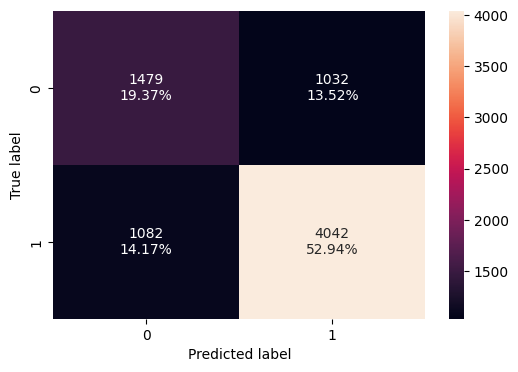

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(abc_tuned, x_test,y_test)

In [ ]:
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned, x_train,y_train)
print("Training performance \n",abc_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.72    0.78       0.79 0.79


In [ ]:
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned, x_test, y_test)
print("Testing performance \n",abc_tuned_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.72    0.79       0.80 0.79


- The AdaBoost classifier after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
- However, this model performs worse than the base model on both the train and test data.

## Tuning GradientBoost Classifier
Most of the hyperparameters available match those of a random forest classifier.

- init: An estimator object that is used to compute the initial predictions. If ‘zero’, the initial raw predictions are set to zero. By default, a DummyEstimator predicting the classes priors is used.
- There is no class_weights parameter in gradient boosting.



In [ ]:
# Choose the type of classifier. 
gb_tuned = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": [150,200,250,300],
              "subsample":[0.8,0.9,1],
              "max_features":[0.7,0.8,0.9,1],
              "learning_rate": np.arange(0.1, 0.4, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_gb = RandomizedSearchCV(gb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_gb = rand_gb.fit(x_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = rand_gb.best_estimator_

# Fit the best algorithm to the data. 
gb_tuned.fit(x_train, y_train)

GradientBoostingClassifier(max_features=0.7, n_estimators=300, random_state=1,
                           subsample=1)

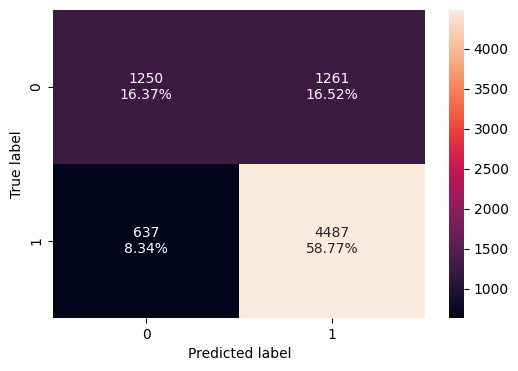

In [ ]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(gb_tuned, x_test,y_test)


In [ ]:
gb_tuned_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


In [ ]:
gb_tuned_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.73    0.91       0.74 0.82


- The Gradient Boosting classifier after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
- However, this model performs slightly worse than the base model on both the train and test data.

## Tuning XGB Classifer
Important parameters include:

- scale_pos_weight:Control the balance of positive and negative weights, useful for unbalanced classes. It has range from 0 to 
.
- subsample: Corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
- colsample_bytree: Corresponds to the fraction of features (the columns) to use.
- colsample_bylevel: The subsample ratio of columns for each level. Columns are subsampled from the set of columns chosen for the current tree.
- colsample_bynode: The subsample ratio of columns for each node (split). Columns are subsampled from the set of columns chosen for the current level.
- max_depth: is the maximum number of nodes allowed from the root to the farthest leaf of a tree.
- learning_rate/eta: Makes the model more robust by shrinking the weights on each step.
- gamma: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.

In [ ]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10,100,20),
              "scale_pos_weight":[0,1,2,5],
              "subsample":[0.5,0.7,0.9,1],
              "learning_rate":[0.01,0.1,0.2,0.05],
              "gamma":[0,1,3],
              "colsample_bytree":[0.5,0.7,0.9,1],
              "colsample_bylevel":[0.5,0.7,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_xgb = RandomizedSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_xgb = rand_xgb.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rand_xgb.best_estimator_

# Fit the best algorithm to the data. 
xgb_tuned.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [ ]:
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned, x_train,y_train)
print("Training performance \n",xgb_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.76    0.88       0.79 0.83


In [ ]:
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned, x_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.76    0.88       0.78 0.83


- The XGBoost classifier after tuning is less overfit than the base model, but performs equally well on the test data.
- This indicates a minor improvement over the base model.

## Stacking Model

Now, let's build a stacking model with the tuned models - decision tree, random forest, and gradient boosting, then use XGBoost to get the final prediction.

In [ ]:
estimators=[('Decision Tree', dtree_estimator),('Random Forest', rf_estimator),
           ('Gradient Boosting', gb_tuned)]
final_estimator=XGBClassifier(random_state=1)

In [ ]:
stacking_estimator=StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(x_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('Decision Tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       max_leaf_nodes=4,
                                                       min_impurity_decrease=0.0001,
                                                       min_samples_leaf=3,
                                                       random_state=1)),
                               ('Random Forest',
                                DecisionTreeClassifier(max_depth=5,
                                                       max_leaf_nodes=4,
                                                       min_impurity_decrease=0.0001,
                                                       min_samples_leaf=3,
                                                       random_state=1)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(m...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None, random_state=1, ...))

In [ ]:
stacking_estimator_model_train_perf = model_performance_classification_sklearn(stacking_estimator, x_train, y_train)
print("Training performance \n",stacking_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.88       0.78 0.83


In [ ]:
stacking_estimator_model_test_perf = model_performance_classification_sklearn(stacking_estimator, x_test, y_test)
print("Training performance \n",stacking_estimator_model_test_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.75    0.88       0.78 0.82


## Model Performance Comparison and Conclusions

##Tuned models comparison

In [ ]:
# create a dataframe comparing the performance of the tuned models on the training data

tuned_models_train_comp_df = pd.concat(
    [dtree_estimator_model_train_perf.T,
     bagging_estimator_model_train_perf.T,
     rf_estimator_model_train_perf.T,
     abc_tuned_model_train_perf.T, 
     gb_tuned_model_train_perf.T, 
     xgb_tuned_model_train_perf.T,stacking_estimator_model_train_perf.T],
    axis=1,
)
tuned_models_train_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier",
    "Stacking Classifier"
]
print("Training performance comparison of tuned models:")
tuned_models_train_comp_df

Training performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier,Stacking Classifier
Accuracy,0.73,0.99,0.73,0.72,0.73,0.76,0.75
Recall,0.91,1.00,0.91,0.78,0.91,0.88,0.88
Precision,0.74,0.99,0.74,0.79,0.74,0.79,0.78
F1,0.82,0.99,0.82,0.79,0.82,0.83,0.83


In [ ]:
# create a dataframe comparing the performance of the tuned models on the testing data

tuned_models_test_comp_df = pd.concat(
    [dtree_estimator_model_test_perf.T,
     bagging_estimator_model_test_perf.T,
     rf_estimator_model_test_perf.T,
     abc_tuned_model_test_perf.T, 
     gb_tuned_model_test_perf.T, 
     xgb_tuned_model_test_perf.T, stacking_estimator_model_test_perf.T],
    axis=1,
)
tuned_models_test_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier",
    "Stacking Classifier"]
print("Testing performance comparison of tuned models:")
tuned_models_test_comp_df

Testing performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier,Stacking Classifier
Accuracy,0.73,0.73,0.73,0.72,0.73,0.76,0.75
Recall,0.91,0.87,0.91,0.79,0.91,0.88,0.88
Precision,0.74,0.76,0.74,0.80,0.74,0.78,0.78
F1,0.82,0.81,0.82,0.79,0.82,0.83,0.82


## **Model Performance Comparison**

In [ ]:
# create a dataframe comparing the performance all models on the training data
all_models_train_comp = pd.concat([models_train_comp_df,tuned_models_train_comp_df],axis=1)
all_models_train_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Decision Tree,1.00,1.00,1.00,1.00
Random Forest,1.00,1.00,1.00,1.00
Tuned Bagging Classifier,0.99,1.00,0.99,0.99
Bagging Classifier,0.98,0.98,0.99,0.99
XGBoost Classifier,0.81,0.92,0.82,0.87
Tuned XGBoost Classifier,0.76,0.88,0.79,0.83
Stacking Classifier,0.75,0.88,0.78,0.83
Gradient Boosting Classifier,0.75,0.87,0.78,0.83
Tuned Decision Tree,0.73,0.91,0.74,0.82
Tuned Random Forest,0.73,0.91,0.74,0.82


In [ ]:
'The best performing model on the training data is the ' + all_models_train_comp.T.sort_values('F1',ascending=False).index[0]


'The best performing model on the training data is the Decision Tree'

In [ ]:
# create a dataframe comparing the performance of all models on the testing data
all_models_test_comp = pd.concat([models_test_comp_df,tuned_models_test_comp_df],axis=1)
all_models_test_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Tuned XGBoost Classifier,0.76,0.88,0.78,0.83
Gradient Boosting Classifier,0.75,0.88,0.78,0.83
Stacking Classifier,0.75,0.88,0.78,0.82
AdaBoost Classifier,0.74,0.89,0.76,0.82
XGBoost Classifier,0.75,0.87,0.78,0.82
Tuned Decision Tree,0.73,0.91,0.74,0.82
Tuned Random Forest,0.73,0.91,0.74,0.82
Tuned Gradient Boosting Classifier,0.73,0.91,0.74,0.82
Tuned Bagging Classifier,0.73,0.87,0.76,0.81
Tuned AdaBoost Classifier,0.72,0.79,0.80,0.79


In [ ]:
'The best performing model on the testing data is the ' + all_models_test_comp.T.sort_values('F1',ascending=False).index[0]


'The best performing model on the testing data is the Tuned XGBoost Classifier'

### Observations
- As expected the Decision Tree model performs the best on the training dataset, since the model will significantly overfit this data unless pruned otherwise.

- The Tuned XGBoost Classifier classifier performs the **best** on the testing dataset, with an 0.83 F1 score. Secondly, The base Gradient Boosting classifier performs well.
- Interestingly, six models tied for the second-best performance, with an F1 score of 0.82.

## **Feature importance of: Tuned XGB Classifer**

In [ ]:
"""The importance of features in the tree building 
(The importance of a feature is computed as the (normalized) total 
reduction of the criterion brought by that feature.)"""

print(pd.DataFrame(xgb_tuned.feature_importances_, columns = ["Imp"], 
                   index = x_train.columns).sort_values(by = 'Imp', ascending = False).head(10))

                                   Imp
education_of_employee_High School 0.36
education_of_employee_Master's    0.16
education_of_employee_Doctorate   0.10
has_job_experience_Y              0.08
unit_of_wage_Year                 0.06
continent_Europe                  0.02
continent_North America           0.02
region_of_employment_Midwest      0.02
region_of_employment_West         0.02
full_time_position_Y              0.02


In [ ]:
feature_names = x_train.columns

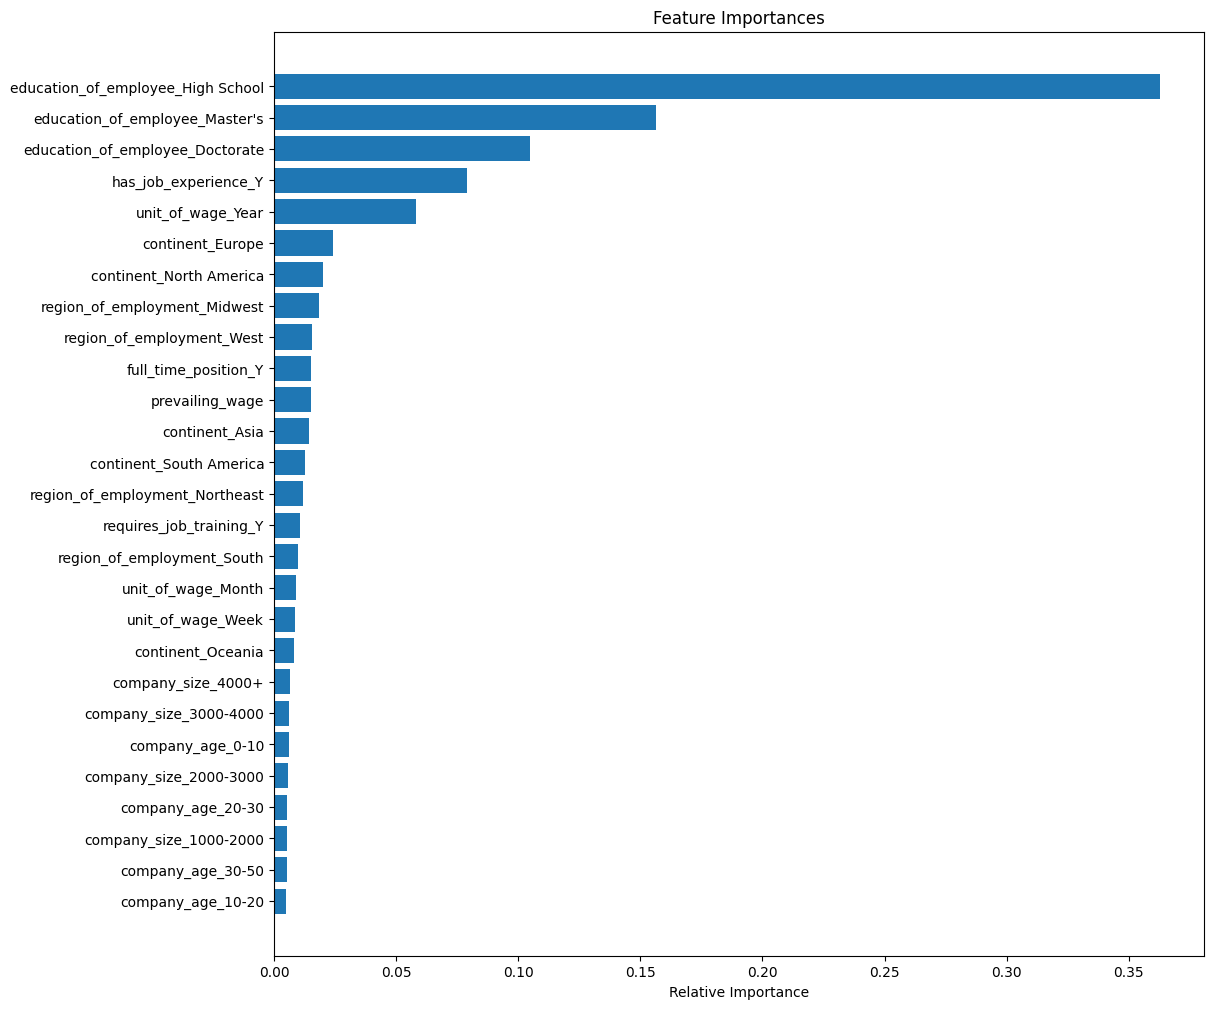

In [ ]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Visualization of Decision Tree (tuned)

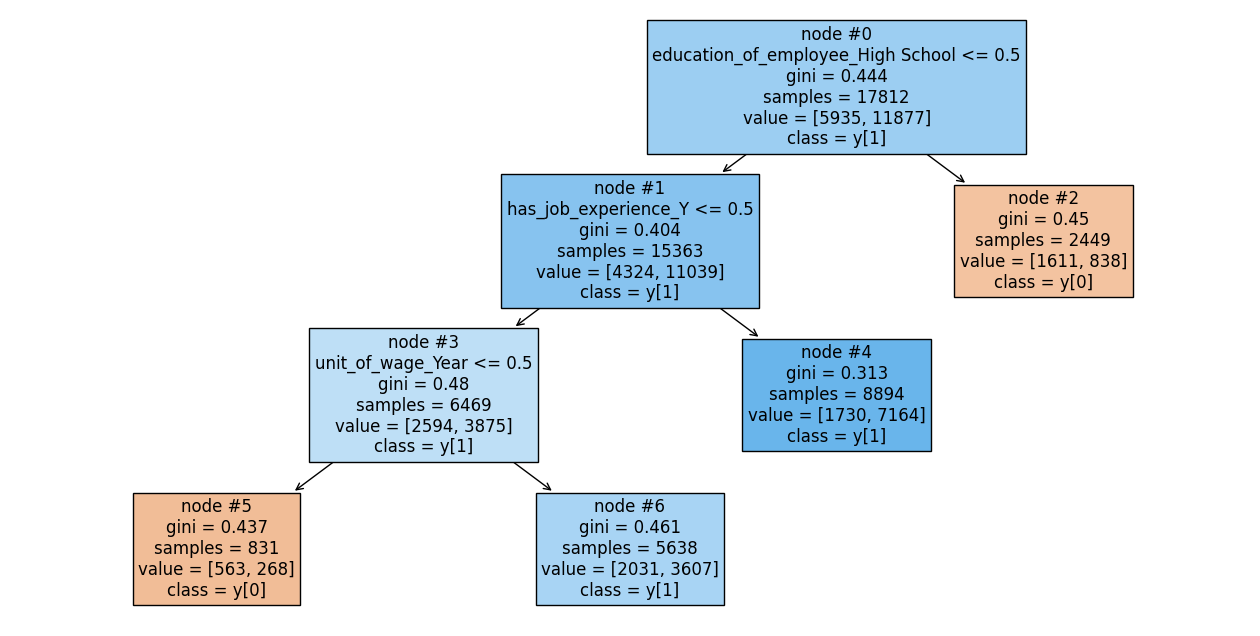

In [ ]:
#create visualization of tuned decision-tree model
feature_names = list(X.columns)
plt.figure(figsize=(16,8))
tree.plot_tree(dtree_estimator,feature_names=feature_names,filled=True,fontsize=12,node_ids=True,class_names=True)
plt.show()

## Actionable Insights and Recommendations

###Insights

To pre-screen an applicant for the Office of Foreign Labor Certification (OFLC), three crucial factors are taken into consideration:

1. Education level:
The OFLC is likely to reject the application of an applicant who has applied for a job that requires a high school diploma. On the other hand, if an applicant has applied for a job that requires a Master's degree or a doctorate, the chances of their application being approved are high.

2. Prior job experience:
An applicant who has no previous job experience is more likely to have their application denied compared to someone who has experience in the relevant field.

3. unit_of_wage_year: The prevailing wage rate per year is an important consideration in the OFLC pre-screening process. The unit of prevailing wage rate per year is used to determine whether an applicant's salary offer meets or exceeds the prevailing wage rate for the specific job and location.

##Recommendations


Based on the pre-screening factors for the Office of Foreign Labor Certification (OFLC), we recommend that businesses pay close attention to these three factors when considering foreign workers for their open positions.

Firstly, it is important to ensure that job applicants meet the required educational qualifications for the specific job. For jobs that require a high school diploma or above, it is important to verify that applicants meet these criteria to avoid any rejections during the pre-screening process.

Secondly, businesses should prioritize applicants with relevant work experience in the specific field. This can increase the chances of their applications being approved by the OFLC.

Lastly, businesses should ensure that they offer a salary that meets or exceeds the prevailing wage rate for the specific job and location. This is a key factor in the OFLC pre-screening process and can help avoid any salary-related rejections.

By taking these factors into account, businesses can increase their chances of successfully hiring foreign workers through the OFLC program. This can be beneficial in filling specialized positions and expanding their talent pool.